<a href="https://colab.research.google.com/github/khushidubeyokok/VGG16/blob/main/paper_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replicating the VGG16 model from [VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION](https://arxiv.org/pdf/1409.1556) paper.
##  Our aim is to build a VGG16 model which can classify the images of [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) using very deep CNN networks.

## Loading data
- Our dataset : [`torchvision.datasets.Food101`](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) consists of 101 food categories with 101,000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images.

In [ ]:
# import required libaries
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import random

In [ ]:
# device agnostic code
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
# create data path
from pathlib import Path

data_path=Path('data')
if not data_path.is_dir():
  print(f"{data_path} downloading")
  data_path.mkdir()
else:
  print(f"{data_path} already exists")

data downloading


In [ ]:
# create transforms
train_transform=transforms.Compose([transforms.Resize(size=[224,224]),transforms.TrivialAugmentWide(num_magnitude_bins=31),transforms.RandomSolarize(threshold=0.5),transforms.ToTensor()])
test_transform=transforms.Compose([transforms.Resize(size=[224,224]),transforms.RandomSolarize(threshold=0.5),transforms.ToTensor()])

In [ ]:
# load the dataset
train_data=datasets.Food101(root=data_path/'train',split='train',transform=train_transform,download=True,target_transform=None)
test_data=datasets.Food101(root=data_path/'test',split='test',transform=test_transform,download=True,target_transform=None)

100%|██████████| 4996278331/4996278331 [00:57<00:00, 86490936.12it/s]


Extracting data/train/food-101.tar.gz to data/train


100%|██████████| 4996278331/4996278331 [01:01<00:00, 81869204.10it/s]


Extracting data/test/food-101.tar.gz to data/test


In [ ]:
len(train_data),len(test_data)

(75750, 25250)

In [ ]:
class_names=train_data.classes

In [ ]:
image,label=train_data[0][0],train_data[0][1]
image.shape,label

(torch.Size([3, 224, 224]), 23)

(-0.5, 223.5, 223.5, -0.5)

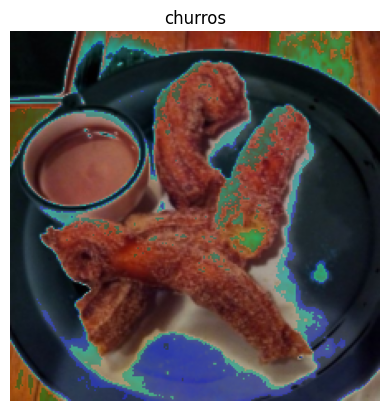

In [ ]:
# view first image sample
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [ ]:
# convert dataset into dataloaders
from torch.utils.data import DataLoader
train_dataloader=DataLoader(dataset=train_data,batch_size=32,shuffle=True)
test_dataloader=DataLoader(dataset=test_data,batch_size=32,shuffle=False)

In [ ]:
len(train_dataloader),len(test_dataloader)

(2368, 790)

In [ ]:
img,label=next(iter(train_dataloader))
img.shape,label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## Build a VGG16 model- 138 million parameters
### **Architecture**
- the input to our ConvNets is a fixed-size 224 × 224 RGB image
- The image is passed through a stack of convolutional (conv.) layers, where we use filters with a very small receptive field: 3 × 3
- The convolution stride is fixed to 1 pixel; the padding is 1 pixel for 3 × 3 conv. layers
-  Spatial pooling is carried out by five max-pooling layers,Max-pooling is performed over a 2 × 2 pixel window, with stride 2.
- A stack of convolutional layers (which has a different depth in different architectures) is followed by three Fully-Connected (FC) layers: the first two have 4096 channels each, the third performs 1000- way ILSVRC classification and thus contains 1000 channels (one for each class). The final layer is the soft-max layer.
- All hidden layers are equipped with the rectification (ReLU) non-linearity.


In [ ]:
from torch import nn
class VGG16_model_repl(nn.Module):
  def __init__(self,input,output):
    super().__init__()
    self.layers=nn.Sequential(
        # First block - conv3-64 (2)
        nn.Conv2d(in_channels=input,out_channels=64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),

        # Second block - conv3-128 (2)
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),

        # Third block - conv3-256 (3)
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),

        # Fourth block - conv3-512 (3)
        nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),

        # Fifth block - conv3-512 (3)
        nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),
        )

     # FC-4096,FC-4096,FC-1000,soft-max
    self.fc_layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(512 * 7 * 7, 4096),  #image size is 224x224
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(4096, 4096),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(4096,output),
      )


  def forward(self,x):
    x=self.layers(x)
    x=self.fc_layers(x)
    return x

In [ ]:
# Create a instance of our model
torch.manual_seed(42)
model_0=VGG16_model_repl(3,len(class_names)).to(device)
model_0

VGG16_model_repl(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=

In [ ]:
try:
  import torchinfo
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

summary(model_0, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG16_model_repl                         [32, 101]                 --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [32, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 64, 224, 224]        36,928
│    └─ReLU: 2-4                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [32, 128, 112, 112]       73,856
│    └─ReLU: 2-7                         [32, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [32, 128, 112, 112]       147,584
│    └─ReLU: 2-9                         [32, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [32, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [32, 256, 56, 56]         29

In [ ]:
# Dummy pass
x=torch.randn(size=[1,3,224,224])
y_pred=model_0(x)
y_pred.shape

torch.Size([1, 101])

## Set up optimiser and loss function

In [ ]:
try:
  import torchmetrics
except:
  !pip install torchmetrics
  from torchmetrics import Accuracy
lossfn=nn.CrossEntropyLoss()
optimiser=torch.optim.Adam(params=model_0.parameters(),lr=0.01)
accuracy=Accuracy(task='multiclass',num_classes=len(class_names)).to(device)

## Training and testing

In [ ]:
def train_step(self, model, train_dataloader, loss_function, optimiser, accuracy_function):
    train_loss = 0
    train_acc = 0

    model.train()  # Set the model to training mode
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)  # Move data to the correct device (GPU/CPU)

        # Forward pass
        y_logit = model(X)
        y_pred = torch.argmax(torch.softmax(y_logit, dim=1), dim=1)

        # Calculate loss
        loss = loss_function(y_logit, y)

        # Calculate accuracy
        acc = accuracy_function(y_pred, y)

        # Backward pass and optimization
        optimiser.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients
        optimiser.step()       # Update model parameters

        # Accumulate loss and accuracy
        train_loss += loss.item()
        train_acc += acc.item()

    # Calculate average loss and accuracy for the epoch
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    return train_loss, train_acc


In [ ]:
def test_step(self,model,test_dataloader,loss_function,accuracy_function):
  model.to(device)
  model.eval()
  test_loss,test_acc=0,0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y.to(device)  # Move data to the correct device (GPU/CPU)

        # Forward pass
        y_logit = model(X)
        y_pred = torch.argmax(torch.softmax(y_logit, dim=1), dim=1)

        # Calculate loss
        loss = loss_function(y_logit, y)

        # Calculate accuracy
        acc = accuracy_function(y_pred, y)

        # Accumulate loss and accuracy
        test_loss += loss.item()
        test_acc += acc.item()

    # Calculate average loss and accuracy for the epoch
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    return test_loss, test_acc

In [ ]:
def train_and_test_model(model,epochs,train_dataloader,test_dataloader,loss_function,optimiser,accuracy_fn):
  from timeit import default_timer as timer
  from tqdm.auto import tqdm
  start = timer()
  results={"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []}
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc=train_step(model,train_dataloader,loss_function,optimiser,accuracy_fn)
    test_loss,test_acc=test_step(model,test_dataloader,loss_function,optimiser,accuracy_fn)
    print(f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc*100:.4f}% | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc*100:.4f}%")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  end = timer()
  time_taken=end-start
  print(f"time_taken:{time_taken}")
  return results


In [ ]:
## !!!! Training this model necessitates a GPU and a longer time commitment, which I currently cannot accommodate. Please uncomment the line to initiate model training.
# model_0_results=train_and_test_model(model_0,3,train_dataloader,test_dataloader,lossfn,optimiser,accuracy)

## Plot loss curves

In [ ]:
from typing import Dict,List,Tuple
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    train_loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    train_accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();


In [ ]:
# !!!!! Uncomment after training
# plot_loss_curves(model_0_results)

## Plot predictions on custom image

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

In [ ]:
# download custom image
import requests

# get custom image path
custom_image_path= data_path/'custom.jpeg'
if not custom_image_path.is_file():
  with open(custom_image_path,'wb') as f:
    print(f"downloading {custom_image_path}")
    request=requests.get('https://t3.ftcdn.net/jpg/00/27/57/96/360_F_27579652_tM7V4fZBBw8RLmZo0Bi8WhtO2EosTRFD.jpg')
    f.write(request.content)
    print(f"{custom_image_path} downloaded")
else:
  print(f"{custom_image_path} already exist")

downloading data/custom.jpeg
data/custom.jpeg downloaded


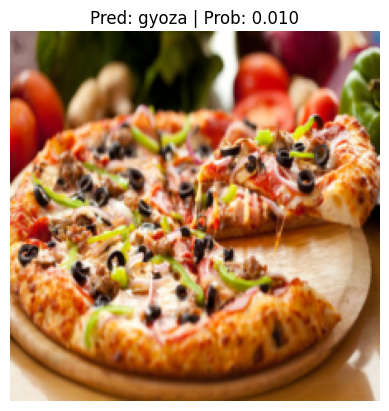

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=transforms.Resize(size=[224,224]),
                    device=device)

# !!!! The prediction would mostly be wrong since our model is not trained yet